In [1]:
import torch 
import pandas
# !pip install scipy==1.1.0
# from scipy.misc import imread
import glob
import math
import matplotlib.pyplot as plt
import multiprocessing
import PIL
from PIL import Image
import openslide
import os
from glob import glob
import sys
import numpy as np
%load_ext autoreload
%aimport utils

# import utils

from tqdm.auto import tqdm
from PIL import Image, ImageDraw, ImageFont
import skimage.color as sk_color
import skimage.exposure as sk_exposure
import skimage.feature as sk_feature
import skimage.filters as sk_filters
import skimage.future as sk_future
import skimage.morphology as sk_morphology
import skimage.segmentation as sk_segmentation
import scipy.ndimage.morphology as sc_morph
from enum import Enum
from utils import *

In [2]:
!dir

 Volume in drive C is OSDisk
 Volume Serial Number is CCE2-CF5A

 Directory of c:\Users\S20153191\Downloads\openslide-win64-20171122\openslide-win64-20171122\bin

09/07/2021  18:37    <DIR>          .
09/07/2021  18:37    <DIR>          ..
12/07/2021  14:51         1,742,828 EPISEGG.ipynb
09/06/2021  15:13            34,835 iconv.dll
09/06/2021  15:13           123,221 iconv.dll.debug
09/06/2021  15:13           882,707 libcairo-2.dll
09/06/2021  15:13         7,355,931 libcairo-2.dll.debug
09/06/2021  15:13            33,299 libffi-6.dll
09/06/2021  15:13           194,252 libffi-6.dll.debug
09/06/2021  15:13           262,163 libgdk_pixbuf-2.0-0.dll
09/06/2021  15:13         1,231,533 libgdk_pixbuf-2.0-0.dll.debug
09/06/2021  15:13         1,355,795 libgio-2.0-0.dll
09/06/2021  15:13         8,666,528 libgio-2.0-0.dll.debug
09/06/2021  15:13         1,281,043 libglib-2.0-0.dll
09/06/2021  15:13         4,563,429 libglib-2.0-0.dll.debug
09/06/2021  15:13            24,083 libgmodule-2

In [3]:
SCALE_FACTOR = 8

TISSUE_HIGH_THRESH = 80
TISSUE_LOW_THRESH = 10
ALLOWED_TISSUE_PERCENTAGE = 58
ROW_TILE_SIZE = 1024
COL_TILE_SIZE = 1024
NUM_TOP_TILES = 50
DISPLAY_TILE_SUMMARY_LABELS = True
TILE_LABEL_TEXT_SIZE = 20
LABEL_ALL_TILES_IN_TOP_TILE_SUMMARY = True
BORDER_ALL_TILES_IN_TOP_TILE_SUMMARY = True

TILE_BORDER_SIZE = 10  # The size of the colored rectangular border around summary tiles.

HIGH_COLOR = (0, 255, 0)
MEDIUM_COLOR = (255, 255, 0)
LOW_COLOR = (255, 165, 0)
NONE_COLOR = (255, 0, 0)

FADED_THRESH_COLOR = (128, 255, 128)
FADED_MEDIUM_COLOR = (255, 255, 128)
FADED_LOW_COLOR = (255, 210, 128)
FADED_NONE_COLOR = (255, 128, 128)

FONT_PATH = "D:/Other/DOWNLOADS/ae_Salem.ttf"
SUMMARY_TITLE_FONT_PATH = "D:/Other/DOWNLOADS/ae_Salem.ttf"
SUMMARY_TITLE_TEXT_COLOR = (0, 0, 0)
SUMMARY_TITLE_TEXT_SIZE = 24
SUMMARY_TILE_TEXT_COLOR = (255, 255, 255)
TILE_TEXT_COLOR = (0, 0, 0)
TILE_TEXT_SIZE = 36
TILE_TEXT_BACKGROUND_COLOR = (255, 255, 255)
TILE_TEXT_W_BORDER = 5
TILE_TEXT_H_BORDER = 4

HSV_PURPLE = 270
HSV_PINK = 330

In [4]:
#Consts
DEST_MAIN_DIR="D:\\Other\\DOWNLOADS\\WSIData"
BASE_PNG_DIR="training_PNG"
PNG_org_DIR = os.path.join(DEST_MAIN_DIR,BASE_PNG_DIR)
PNG_ANN_DIR = os.path.join(DEST_MAIN_DIR,BASE_PNG_DIR+"_annotation")
annotated_file_names = sorted(glob("D:\\Other\\DOWNLOADS\\WSIData\\annotated\*"))
PNG_original_file_names = sorted(glob(PNG_org_DIR+"\*"))
PNG_annotated_file_names =sorted(glob(PNG_ANN_DIR+"\*"))
print(len(original_file_names),len(annotated_file_names))
print(len(PNG_original_file_names),len(PNG_annotated_file_names))

0 0
0 0


# Genertating PNG files from Tif 
target dir goes in --> enumerate () # below 

In [75]:
#Converting the tif into a png for processing int he cores_tiles func 
for idx,path in enumerate(original_file_names):
    print("Done %d out of %d"%(idx,len(original_file_names)))
    imgpath=path
    slide_info(imgpath)
    training_slide_to_image(imgpath,DEST_TRAIN_DI="V:\wsi-slides\scaled_peso_tif",scale_factor=SCALE_FACTOR)

Done 0 out of 1

Opening Slide #1: V:\wsi-slides\peso_tif\pds_22_HE.tif
Level count: 8
Level dimensions: ((47484, 105289), (23742, 52644), (11871, 26322), (5935, 13161), (2967, 6580), (1483, 3290), (741, 1645), (370, 822))
Level downsamples: (1.0, 2.000009497758529, 4.000018995517058, 8.000374975027377, 16.002706135269115, 32.010808104823255, 64.04322139226954, 128.21197146051162)
Dimensions: (47484, 105289)
Associated images:
Format: generic-tiff
Scaling to 32 ...
Scaling to 32 ...
Opening Slide : V:\wsi-slides\peso_tif\pds_22_HE.tif
Saving image to: V:\wsi-slides\scaled_peso_tif\pds_22_HE.png


In [79]:
#Converting the tif into a png for processing int he cores_tiles func 
for idx,path in enumerate(annotated_file_names):
    print("Done %d out of %d"%(idx,len(original_file_names)))
    imgpath=path
    slide_info(imgpath)
    training_slide_to_image(imgpath,DEST_TRAIN_DI="V:\wsi-slides\scaled_annotated_test_dir",scale_factor=SCALE_FACTOR)

Done 0 out of 1

Opening Slide #1: V:\wsi-slides\annotated_test_dir\pds_22_HE_training_mask.tif
Level count: 8
Level dimensions: ((47484, 105289), (23742, 52644), (11871, 26322), (5935, 13161), (2967, 6580), (1483, 3290), (741, 1645), (370, 822))
Level downsamples: (1.0, 2.000009497758529, 4.000018995517058, 8.000374975027377, 16.002706135269115, 32.010808104823255, 64.04322139226954, 128.21197146051162)
Dimensions: (47484, 105289)
Associated images:
Format: generic-tiff
Scaling to 32 ...
Scaling to 32 ...
Opening Slide : V:\wsi-slides\annotated_test_dir\pds_22_HE_training_mask.tif
Saving image to: V:\wsi-slides\scaled_annotated_test_dir\pds_22_HE_training_mask.png
Done 1 out of 1

Opening Slide #1: V:\wsi-slides\annotated_test_dir\pds_4_HE_training_mask.tif
Level count: 8
Level dimensions: ((47484, 105289), (23742, 52644), (11871, 26322), (5935, 13161), (2967, 6580), (1483, 3290), (741, 1645), (370, 822))
Level downsamples: (1.0, 2.000009497758529, 4.000018995517058, 8.000374975027377

In [ ]:

list_names = l.split(",")
list_names = [x.strip() for x in list_names]
on_disk_names = [os.path.basename(s) for s in PNG_original_file_names ]


In [ ]:
def get_num_lis(lis):
    lis = [x.split("_")[1] for x in lis if len(x.split("_")) >1 ]
    return lis
def get_num(path):
    return os.path.basename(path).split("_")[1]

def get_diff(lis1,lis2):
    lis1 = get_num_lis(lis1)
    lis2 = get_num_lis(lis2)
    diff = [x for x in lis1 if x not in lis2]
    return diff, len(diff)
diff, len_diff = get_diff(list_names,on_disk_names)
diff, len_diff

In [ ]:
for idx,path in enumerate(original_file_names):
    print("Done %d out of %d"%(idx,len(original_file_names)))
    imgpath=path
    slide_num = get_num((imgpath))
    if (slide_num) in diff: 
        print(slide_num)

        slide_info(imgpath)
        training_slide_to_image(imgpath)

In [ ]:
%run utils.py
for idx,path in enumerate(annotated_test_dir):
    print("Done %d out of %d --- %s"%(idx,len(annotated_test_dir),path))
    imgpath=path
    slide_num = get_num_norm((imgpath))
    print(slide_num)
    slide_info(imgpath)
    training_slide_to_image(imgpath,_dir)

## How to open slide and view stats 

In [ ]:
#owrkflow for genertating test tiles   - step 1

imgpath = "D:\Other\DOWNLOADS\WSIData\\Normal\\Original\\3IFMr1c8.tif"


In [ ]:
slide_info(imgpath)


In [ ]:
Slide = open_slide(imgpath)
slide_to_scaled_pil_image(imgpath,SCALE_FACTOR)[0].show()


In [ ]:
Slide = open_slide(imgpath)
im=slide_to_scaled_pil_image(imgpath,8)
np_im=np.array(im[0])
np_im[np_im==1]=0
np_im[np_im==2]=255
np.unique(np_im,return_counts=True)
np_to_pil(np_im).save("D:\Other\DOWNLOADS\WSIData\\22_mask.png")

In [ ]:
#owrkflow for genertating test tiles   - step 2 
test_slide_to_image(imgpath,SCALE_FACTOR)
test_slide_to_image(annotation_imgpath,SCALE_FACTOR)

In [ ]:
 os.path.dirname(imgpath)

# Filters


In [ ]:
ann = to_np(open_image(PNG_annotated_file_names[0]))
img = to_np(open_image(PNG_original_file_names[0]))

In [ ]:
#view epithilial cells mask 
display_img(mask_epi(ann),"Epithlial cells",size = 100)

In [ ]:
#kmeans segmentatioa n
n_segments = 30000
display_img(filter_kmeans_segmentation((img),n_segments=n_segments),"K-Means with %d"%(n_segments))

In [ ]:
display_img(filter_rag_threshold(img),"K-Means_rag with %d"%(n_segments))

In [ ]:
test_im_path = 'D:\\Other\\DOWNLOADS\\WSIData\\training_PNG\\3IFT-08Q-CD3-2012-03-2019.04.42_3883_C02R01_ImageActualTif.png'
test_im_np = open_image_np(test_im_path)
%run utils.py

np_to_pil(apply_image_filters(test_im_np,test_im_path,save=True))

# Tiling

In [ ]:
#clossing a mask to geft all are that is annotated (takes alot of time tho) 
display_img(filter_binary_closing(mask_epi(filter_rgb_to_grayscale(ann)),disk_size=25,),"Allowed cells",size = 100)

In [ ]:
i=0
im_path = PNG_original_file_names[i]


In [ ]:
display_img(get_mask_focused(im_path))

In [ ]:
#owrkflow for genertating test tiles   - step 3 pick the png image from the list of png test images 

PNG_dir = glob(FILTER_DIR+"\PNG\*.png")
test = PNG_dir[1]
test

In [ ]:
# run / reload utils
annotated_test_dir 

In [ ]:
#owrkflow for genertating test tiles   - step 4

#first is the slide path of the test slide 
test_im_path = 'D:\\Other\\DOWNLOADS\\WSIData\\filtered\\pds_22_HE.tif' 
#get dimensions 
imgpath = get_slide_path_based_on_PNG_path(test,test=True)
_,o_w,o_h,w,h = slide_to_scaled_pil_image(imgpath,SCALE_FACTOR)
tile_sum = score_tiles(test,dimensions=(o_w,o_h,w,h),test=True)

In [6]:
%run utils.py

_dir = "D:\\Other\\DOWNLOADS\\WSIData\\Normal\\Original\\PNG\\"
_dir_all = sorted(glob(_dir+'\*'))    

In [ ]:
tile_sum = score_tiles(_dir_all[0],test=True)

In [ ]:
np_ = get_mask_for_test(_dir_all[0])
print(np_.shape)
np_to_pil(np_[5120:5960,0 :5960 ])

In [ ]:
tile_sum.top_tiles()


In [ ]:
t = tile_sum.get_tile(4,10)
t.get_pil_tile()

In [ ]:
n = np.array(np_tile_to_pil_tile(t))
print(np.unique(n,return_counts=True))
n[n==2]=0
np_to_pil(n)

In [ ]:
n[n!= 159]=0
np_to_pil(n)

In [ ]:
# t = tile_sum.get_tile(12,14)
a,b=t.get_np_ann_tile()


In [ ]:
#owrkflow for genertating test tiles   - step 5

ALLOWED_TISSUE_PERCENTAGE = 70
for t in tile_sum.top_tiles():
    if t.tissue_percentage > ALLOWED_TISSUE_PERCENTAGE:
        t.save_tile()

# creating dataset !!!

In [ ]:
#creating training tiles 
for idx,path in enumerate(annotated_tif_test_dir):
    print("#%d##Genertaing tiles for %s"%(idx,path))
    tile_sum = score_tiles(path)
    for t in tile_sum.top_tiles():
        if t.tissue_percentage > 58:
            t.save_tile()

In [ ]:
#Creating a dataset of test tiles  

for idx,path in enumerate(_dir_all):
    print("#%d##Genertaing tiles for %s"%(idx,path))

    imgpath = get_slide_path_based_on_PNG_path(path,test=True)
    dim = slide_to_scaled_pil_image(imgpath,SCALE_FACTOR)
    tile_sum=score_tiles(im_path,dimensions=dim[1:],test=True)
    for t in tile_sum.top_tiles():
        # print(t.tissue_percentage)

        if t.tissue_percentage > 0:

            t.save_tile()

# Tile summary 

getting slide:22
Scaling to 32 ...
Opening Slide : V:\wsi-slides\peso_tif\pds_22_HE.tif
Getting mask for slide num: 22
V:\wsi-slides\scaled_annotated_test_dir\pds_22_HE_training_mask.png
[0 1 2]
Using the mask for tissue percentage . . . 
47484 105289 (3290, 1483, 3)
Tile size on PNG: 32 - 32


32 32
number of rows,cols for summary : (3596, 1504)
number of rows,cols for summary : (3596, 1504)


In [84]:
for t in tile_sum.top_tiles():
    print(t.score)

    if t.score > .70:

        t.save_tile()


  [1 1 1]]]
Retrived this slide : V:\wsi-slides\annotated_test_dir\pds_22_HE_training_mask.tif
[0 1 2]
Retrived this slide : V:\wsi-slides\annotated_test_dir\pds_22_HE_training_mask.tif
[0 1 2]
[0 1 2]
0.7054684169158273
getting slide:22
Retrived this slide : V:\wsi-slides\peso_tif\pds_22_HE.tif
[[[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 ...

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Retrived this slide : V:\wsi-slides\annotated_test_dir\pds_22_HE_training_mask.tif
[0 1 2]
Retrived this slide : V:\wsi-slides\annotated_test_dir\pds_22_HE_training_mask.tif
[0 1 2]
[0 1 2]
0.7052048463271072
getting slide:22
Retrived this slide : V:\wsi-slides\peso_tif\pds_22_HE.tif
[[[

In [ ]:
summ.save(f'V:img('+str(os.path.basename(im_path))+')_tiles.png')

In [13]:
summ,sum_org = generate_top_tile_summaries(tile_sum,(im_path))

using the normal path num retrival
512 512
number of rows,cols for summary : (10028, 18432)
number of rows,cols for summary : (10028, 18432)


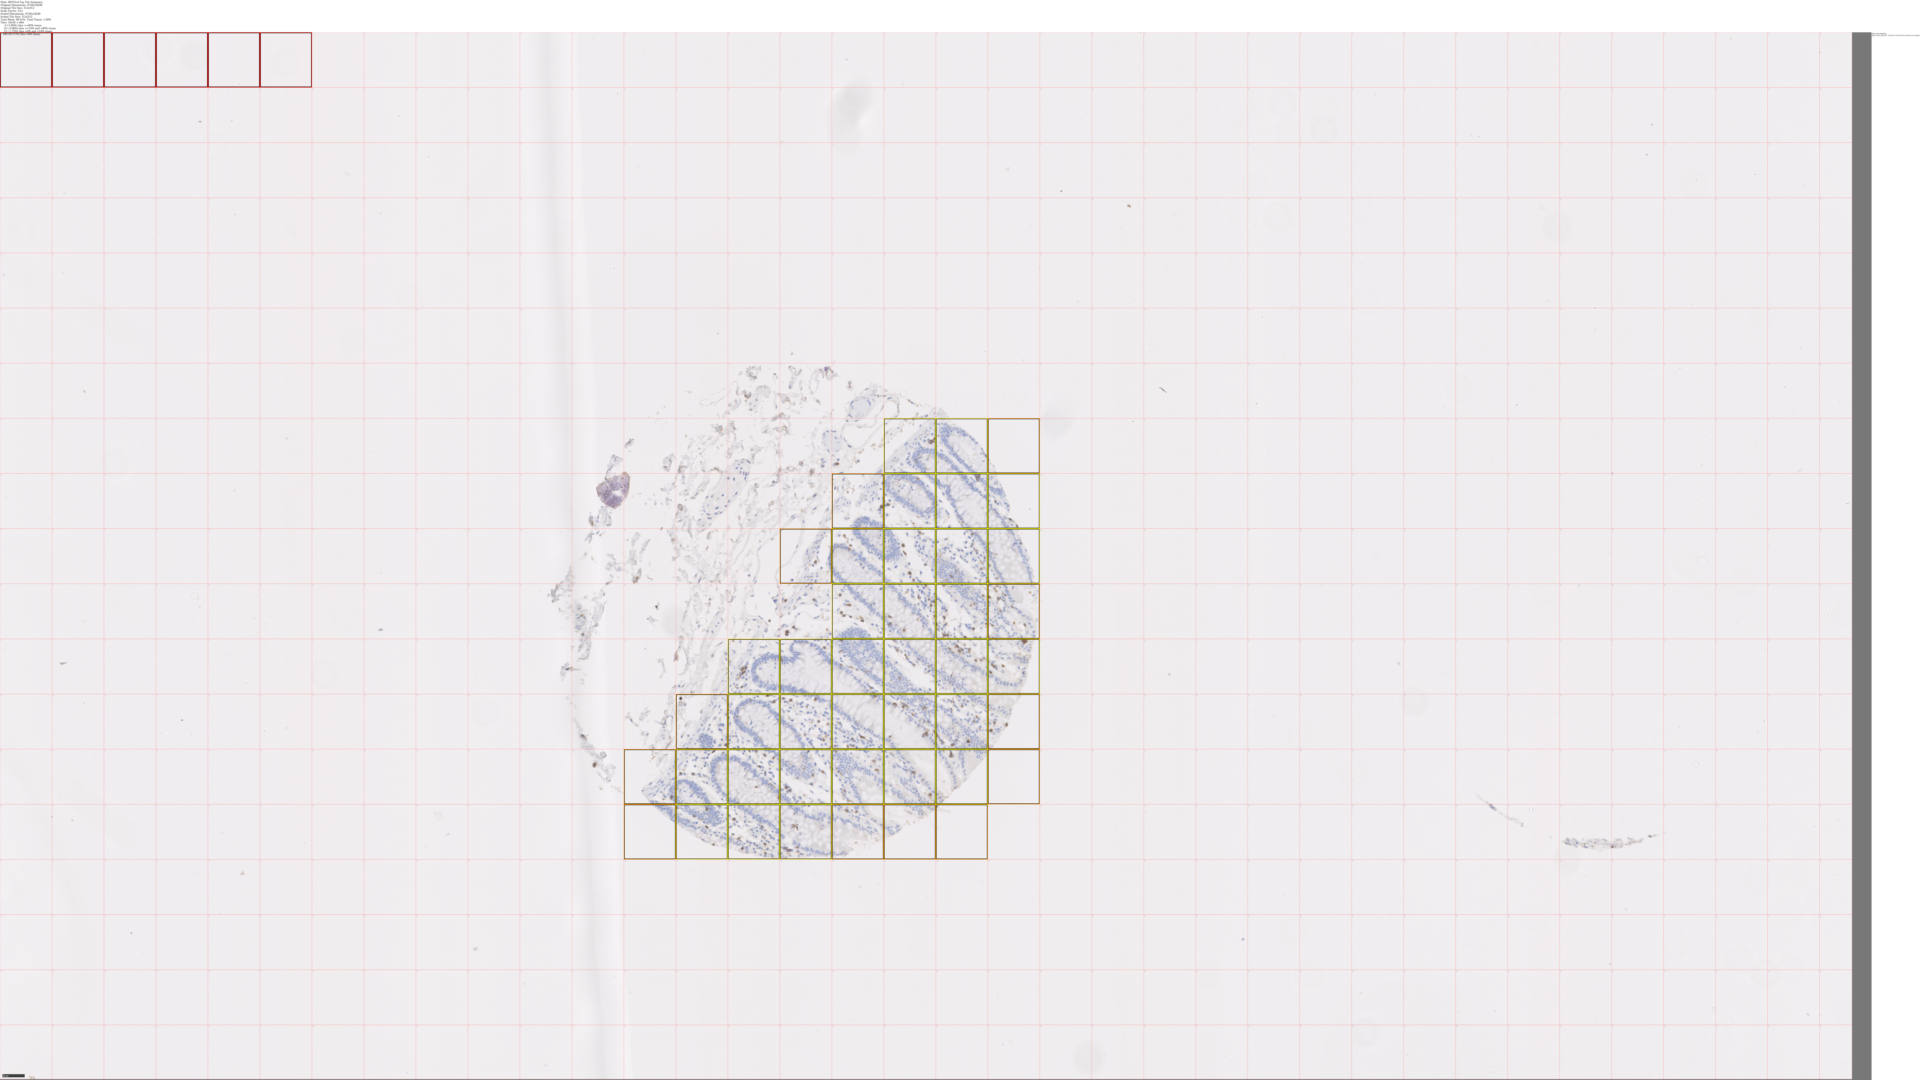

In [14]:
summ.resize((1920,1080), PIL.Image.BILINEAR)

In [ ]:
summ.save(f'./('+str(22)+')_tiles.png')
open_image("./(22)_tiles.png")

In [ ]:
#experimenting with fitting the mask on un-equal res color slides 

In [ ]:
test_co = open_image_np(_dir_all[0]) 
test_co_pil = np_to_pil(test_co)
test_co_pil

In [ ]:
test_co_cropped  = test_co[:8616,:8616,:]

test_co_cropped.shape,test_co.shape

In [ ]:
np_to_pil(matrics[0])

In [ ]:
tag=open_image_np(annotated_test_dir[0])
tag.shape

In [ ]:
def equalize_heights(matrices):
    max_height = matrices[0].shape[0]

    for matrix in matrices[1:]:
        max_height = max(max_height, matrix.shape[0])

    for idx, matrix in enumerate(matrices):
        matrices[idx] = np.concatenate((
            matrix,
            np.zeros((max_height - matrix.shape[0], matrix.shape[1],3))
            ),axis=0)
        print("finsih 1 ")


In [ ]:
h=test_co_cropped.shape[0]

new_arr=np.zeros((8616,8616,3),dtype=np.uint8)
new_arr[:h,:8616,:]=test_co_cropped
new_arr.dtype,test_co_cropped.dtype

# Stain Normalisation 

In [16]:
%run utils.py
tiles=sorted(glob("D:\\Other\\DOWNLOADS\\WSIData\\Normal\\Original\\PNG\\1024\\train\\*"))



In [17]:
# Show example stain transformation
# import cv2 as cv
import matplotlib.pyplot as plt

target=open_image_np(tiles[2])
source = open_image_np(tiles[1])

# Perform stain normalization
transformed = mapping(target,source)

fig = plt.figure()
fig, ax = plt.subplots(1,3, figsize=(20,20))

ax[0].imshow(source)
ax[0].set_title("Source Image",fontsize=14)
ax[1].imshow(target)
ax[1].set_title("Target Image",fontsize=14)
ax[2].imshow(transformed)
ax[2].set_title("Transformed Image",fontsize=14)

NameError: name 'cv' is not defined

In [1]:
import spams

ModuleNotFoundError: No module named 'spams'